In [46]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
import nltk
import os
import codecs
from sklearn import feature_extraction
import mpld3
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import reuters
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

In [1]:
def clean_messages(df):

    stop_words = stopwords.words('english') + ['source', 'ig', 'twitter', 'share', 'igshid', 'hurricane', 'hurricanes', 'florence', 'hurricaneflorence']
    
    df['text'] = df['text'].fillna('')
    messages = df['text'].tolist()

    for i in range(len(messages)):
        #print(messages[i])
        if messages[i] == None:
            messages[i] = ''
        #messages[i] = re.sub('[A-Za-z0-9./]+.com[A-Za-z0-9./]+', " ", messages[i])
        messages[i] = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', messages[i])
        messages[i] = re.sub('[A-Za-z0-9./]+.com[A-Za-z0-9./]+', '', messages[i])
        messages[i] = messages[i].lower()
        messages[i] = re.sub(r'@[A-Za-z0-9]+', " ", messages[i])
        messages[i] = re.sub("[^a-zA-Z]", " ", messages[i])
        #messages[i] = re.sub('https?://[A-Za-z0-9./]+', " ", messages[i])
        messages[i] = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", messages[i]).split())
        messages[i] = ' '.join(re.sub("newline", " ", messages[i]).split())
        
        messages[i] = ' '.join([w for w in word_tokenize(messages[i]) if not w in stop_words])
        
        #print(messages[i])
    df['cleantext'] = messages

    return df

In [48]:
def get_message_sentiments(df):
    messages = df['cleantext'].tolist()

    sentiments = []

    for i in range(len(messages)):
        analysis = TextBlob(messages[i])
        if analysis.sentiment.polarity > 0:
            sentiments.append('positive')
        elif analysis.sentiment.polarity == 0:
            sentiments.append('neutral')
        else:
            sentiments.append('negative')

    df['sentiment'] = sentiments

    return df

In [49]:
def generate_word_cloud(df):
    wc = WordCloud(max_words=100, max_font_size=50, background_color="white").generate(' '.join(df['cleantext'].values))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [50]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [51]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [52]:
def classify_location(df):
    area_class = ['rural','poor','community','communitites','country','countryside','neighborhood',
'impoverished','poverty','broke','underpriviledged','low','income','low-income']
    messages = df['cleantext'].tolist()
    
    location_class = []
    
    for i in range(len(messages)):
        location_class.append('non-rural')
        for word in area_class:
            if word in messages[i]:
                location_class[i] = 'rural'
    
    df['location'] = location_class
    
    return df

In [53]:
tweets_df = pd.read_csv('Mega_tweetsOnly.csv', error_bad_lines = False)

tweets_df.columns = ['text'] #= tweets_df['cleantext']

print(tweets_df.head())

                                                text
0  # HurricaneFlorence  #relief  #Trump  p/status...
1  Anybody in Houston suffering from a little PTS...
2  The latest El Diario de World Vision LAC!   /1...
3  I need you to act right so I can take my daugh...
4  via EpiscopalRelief: RT CDCemergency: In the p...


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [54]:
tweets_df = clean_messages(tweets_df)
print(len(tweets_df))

tweets_df = tweets_df['cleantext'] != ' '
print(len(tweets_df))

139207
139207


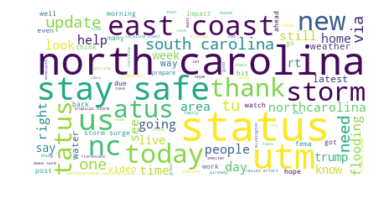

In [10]:
generate_word_cloud(tweets_df)

In [11]:
# assign location classifications
tweets_df = classify_location(tweets_df)
print(tweets_df.head())

                                                text  \
0  # HurricaneFlorence  #relief  #Trump  p/status...   
1  Anybody in Houston suffering from a little PTS...   
2  The latest El Diario de World Vision LAC!   /1...   
3  I need you to act right so I can take my daugh...   
4  via EpiscopalRelief: RT CDCemergency: In the p...   

                                           cleantext   location  
0                              relief trump p status  non-rural  
1  anybody houston suffering little ptsd flashbac...  non-rural  
2  latest el diario de world vision lac edition i...  non-rural  
3  need act right take daughter see pawpatrol wee...  non-rural  
4  via episcopalrelief rt cdcemergency path alway...      rural  


In [12]:
tweets_df = get_message_sentiments(tweets_df)

In [13]:
# separate tweets by sentiment
tweets_df_positive = tweets_df[tweets_df['sentiment'] == 'positive']
tweets_df_negative = tweets_df[tweets_df['sentiment'] == 'negative']
tweets_df_neutral = tweets_df[tweets_df['sentiment'] == 'neutral']

# separate tweets by area class
tweets_df_nonrural = tweets_df[tweets_df['location'] == 'non-rural']
tweets_df_rural = tweets_df[tweets_df['location'] == 'rural']

# separate tweets by sentiment and area class
tweets_df_rural_positive = tweets_df_rural[tweets_df_rural['sentiment'] == 'positive']
tweets_df_rural_negative = tweets_df_rural[tweets_df_rural['sentiment'] == 'negative']
tweets_df_rural_neutral = tweets_df_rural[tweets_df_rural['sentiment'] == 'neutral']

tweets_df_nonrural_positive = tweets_df_nonrural[tweets_df_nonrural['sentiment'] == 'positive']
tweets_df_nonrural_negative = tweets_df_nonrural[tweets_df_nonrural['sentiment'] == 'negative']
tweets_df_nonrural_neutral = tweets_df_nonrural[tweets_df_nonrural['sentiment'] == 'neutral']

print(len(tweets_df_positive))
print(len(tweets_df_negative))
print(len(tweets_df_neutral))

print(len(tweets_df_nonrural))
print(len(tweets_df_rural))

print(len(tweets_df_rural_positive))
print(len(tweets_df_rural_negative))
print(len(tweets_df_rural_neutral))

print(len(tweets_df_nonrural_positive))
print(len(tweets_df_nonrural_negative))
print(len(tweets_df_nonrural_neutral))

51888
19971
67348
132559
6648
2975
1538
2135
48913
18433
65213


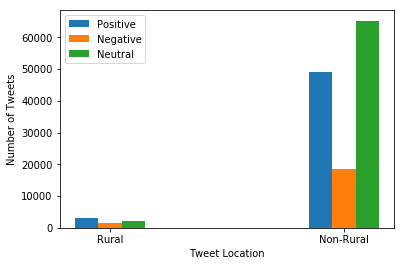

In [14]:
def plot_sentiment_location_breakdown(positives, negatives, neutrals):
    
    x = np.array([1, 3])

    #ax = plt.subplot(111)
    plt.bar(x-0.2, positives,width=0.2,align='center', label = 'Positive')
    plt.bar(x, negatives,width=0.2,align='center', label = 'Negative')
    plt.bar(x+0.2, neutrals,width=0.2,align='center', label = 'Neutral')
    #ax.xaxis_date()
    plt.xticks(x, ['Rural', 'Non-Rural'])
    plt.legend()
    plt.xlabel('Tweet Location')
    plt.ylabel('Number of Tweets')
    plt.show()
    
positive_counts = [len(tweets_df_rural_positive), len(tweets_df_nonrural_positive)]
negative_counts = [len(tweets_df_rural_negative), len(tweets_df_nonrural_negative)]
neutral_counts = [len(tweets_df_rural_neutral), len(tweets_df_nonrural_neutral)]

plot_sentiment_location_breakdown(positive_counts, negative_counts, neutral_counts)

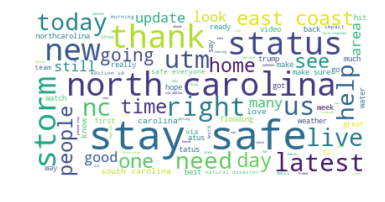

In [15]:
generate_word_cloud(tweets_df_positive)

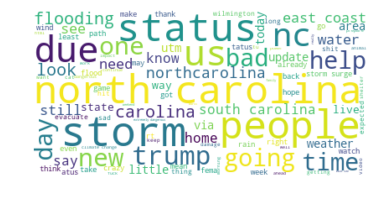

In [16]:
generate_word_cloud(tweets_df_negative)

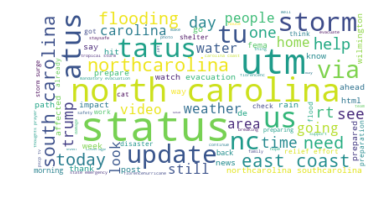

In [17]:
generate_word_cloud(tweets_df_neutral)

In [18]:
tweet_text = list(tweets_df['cleantext'])
tweet_indices = [i for i in range(len(tweets_df))]

In [19]:
stemmer = SnowballStemmer("english")
# tokenize and stem tweets
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in tweet_text: #tweets_df['cleantext']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

print(vocab_frame.head())

there are 1511155 items in vocab_frame
           words
relief    relief
trump      trump
p              p
status    status
anybodi  anybody


In [20]:
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=200000,
                                 min_df=0.05, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(tweet_text) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

(139207, 6)


In [21]:
terms = tfidf_vectorizer.get_feature_names()
#from sklearn.metrics.pairwise import cosine_similarity
#dist = 1 - cosine_similarity(tfidf_matrix)

K-Means


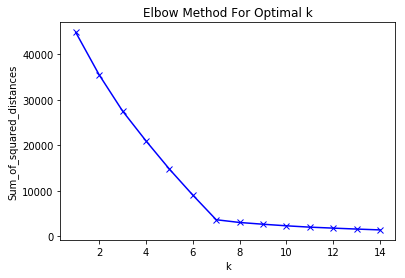

In [22]:
print("K-Means")

from sklearn.cluster import KMeans

Sum_of_squared_distances = []
ks = range(1,15)
for k in ks:
    km = KMeans(n_clusters=k)
    km = km.fit(tfidf_matrix)
    Sum_of_squared_distances.append(km.inertia_)

#clusters = km.labels_.tolist()
plt.plot(ks, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [23]:
# 7 chosen as optimal number of clusters
num_clusters = 7
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

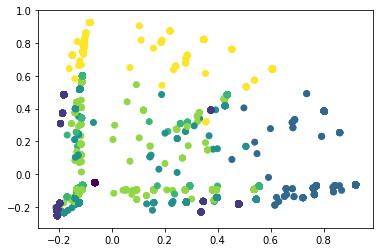

In [24]:
from sklearn.decomposition import PCA
def plot_kmeans_clusters(data, labels):#model):
    X = data.todense()
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    plt.scatter(principalComponents[:,0], principalComponents[:,1], c=labels.astype(float))#model.labels_.astype(float))
    plt.show()
plot_kmeans_clusters(tfidf_matrix, km.labels_)

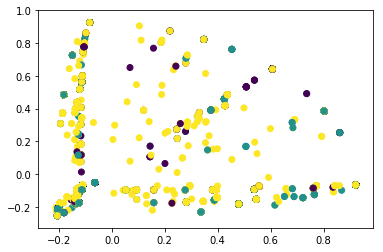

In [25]:
plot_kmeans_clusters(tfidf_matrix, np.array(tweets_df['sentiment'].astype('category').cat.codes))

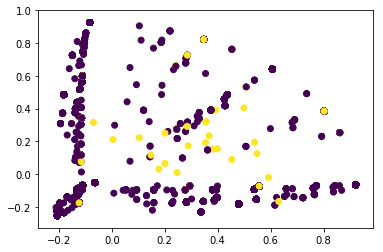

In [26]:
plot_kmeans_clusters(tfidf_matrix, np.array(tweets_df['location'].astype('category').cat.codes))

In [27]:
from sklearn.externals import joblib

#uncomment the below to save your model
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

tweets = { 'tweet_indices': tweet_indices, 'tweet_text': tweet_text, 'cluster': clusters}

frame = pd.DataFrame(tweets, index = [clusters] , columns = ['tweet_indices', 'cluster'])

frame['cluster'].value_counts()

0    91026
2     9179
6     9044
1     7954
3     7714
4     7188
5     7102
Name: cluster, dtype: int64

In [28]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')

    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace

    #print("Cluster %d titles:" % i, end='')
    #for title in frame.ix[i]['tweet_indices'].values.tolist():
    #    print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace

print()
print()

Top terms per cluster:

Cluster 0 words: b'utm',

/home/1eh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


 b'storm', b'status', b'safe', b'helping', b'carolina',



Cluster 1 words: b'status', b'safe', b'helping', b'storm', b'carolina', b'utm',



Cluster 2 words: b'carolina', b'storm', b'safe', b'utm', b'helping', b'status',



Cluster 3 words: b'helping', b'carolina', b'storm', b'safe', b'utm', b'status',



Cluster 4 words: b'safe', b'storm', b'carolina', b'helping', b'status', b'utm',



Cluster 5 words: b'utm', b'carolina', b'storm', b'safe', b'helping', b'status',



Cluster 6 words: b'storm', b'carolina', b'safe', b'utm', b'status', b'helping',







In [29]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [55]:
from gensim import corpora, models, similarities 

print(tweet_text[0])

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in tweet_text]

print(preprocess[0])

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

print(tokenized_text[0])

#remove stop words
text = []
for text in tokenized_text:
    words = []
    for word in text:
        if word in stopwords:
            words.append(word)
    text.append(words)

%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

relief trump p status
CPU times: user 26.3 s, sys: 0 ns, total: 26.3 s
Wall time: 26.3 s
relief trump p status
CPU times: user 51 s, sys: 39.8 ms, total: 51 s
Wall time: 51 s
['relief', 'trump', 'p', 'status']


TypeError: argument of type 'WordListCorpusReader' is not iterable

In [60]:
texts = []
for text in tokenized_text:
    #print(text)
    words = []
    for word in text:
        words.append(word)
    texts.append(words)

In [62]:
texts = [[word for word in text] for text in tokenized_text]

In [63]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

TypeError: decoding to str: need a bytes-like object, list found

In [ ]:
lda = models.LdaModel(corpus, num_topics=5, 
        id2word=dictionary, 
                            update_every=5, 
                            chunksize=10000, 
                            passes=100)